<a href="https://colab.research.google.com/github/ehpower/FrogApp/blob/main/Frog_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connection to Google Drive & Libraries

In [582]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
%matplotlib inline
import numpy as np
!pip install --upgrade gspread
!pip install pygsheets
!pip install ipython-sql

%load_ext sql
import sqlite3 as sql
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [583]:
#Autentícate y crea el cliente de PyDrive.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Para usar la API de Drive, primero debemos autenticarnos y crear un cliente de la API.
from google.colab import auth
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

#Importa la biblioteca, autentícate y crea la interfaz para interactuar con Hojas de cálculo.
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

pd.set_option('display.max_columns', None)

gc = gspread.authorize(creds)


# Connecting the data

In [584]:
#Connecting to copy in Google Sheets
gsheet = gc.open_by_key('1ZxbhbHK2GRhVNKaHuznKUdT-xrimiwzxekcTOcFbOZc')
sheets = gsheet.worksheets()
for sheet in sheets:
    if sheet.title == 'test_data_final':
        rows = sheet.get_all_values()
        df_raw = pd.DataFrame.from_records(data = rows[1:], columns = rows[0])
df_raw.head(4)

,Unnamed: 0,event_timestamp,event_date,country,user_pseudo_id,event_name
0,0,"1.665.273.599.626.000,00",20221008,B,user_0,register_mobile
1,1,"1.665.273.599.626.000,00",20221008,B,user_0,register_mobile
2,2,"1.665.273.599.556.010,00",20221008,B,user_0,event1
3,3,"1.665.273.599.556.010,00",20221008,B,user_0,event1


It seems like the time stamps data is being read in the wrong format. The Date format seems the Unix timestamp format, to work with it I will convert it to common date timestamp format.

To do so I will replace the '.' with blanks and remove the last three characters, to be able to conver it to string, and with the Pandas library change the format.

In [585]:
#Correcting the event_timestamp format (removing "." and ",00")
df_raw.event_timestamp = df_raw.event_timestamp.str.replace('.', '', regex=False).str[:-3].astype(int)


#unit us means that the previous unit of time was microseconds.
df_raw['date_format'] = pd.to_datetime(df_raw['event_timestamp'], unit='us', utc=True)


df_raw['event_timestamp_timezona'] = np.where(df_raw['country']=='A',df_raw['date_format'].dt.tz_convert('Europe/London'),df_raw['date_format'].dt.tz_convert('America/New_York'))

#Erasing the Unnamed column since it does not provide any valuable information.
df_raw.drop('Unnamed: 0', axis=1, inplace=True)

df_raw.head(10)

,event_timestamp,event_date,country,user_pseudo_id,event_name,date_format,event_timestamp_timezona
0,1665273599626000,20221008,B,user_0,register_mobile,2022-10-08 23:59:59.626000+00:00,2022-10-08 19:59:59.626000-04:00
1,1665273599626000,20221008,B,user_0,register_mobile,2022-10-08 23:59:59.626000+00:00,2022-10-08 19:59:59.626000-04:00
2,1665273599556010,20221008,B,user_0,event1,2022-10-08 23:59:59.556010+00:00,2022-10-08 19:59:59.556010-04:00
3,1665273599556010,20221008,B,user_0,event1,2022-10-08 23:59:59.556010+00:00,2022-10-08 19:59:59.556010-04:00
4,1665273575218000,20221008,B,user_1,event2,2022-10-08 23:59:35.218000+00:00,2022-10-08 19:59:35.218000-04:00
5,1665273568534000,20221008,B,user_2,event3,2022-10-08 23:59:28.534000+00:00,2022-10-08 19:59:28.534000-04:00
6,1665273568534000,20221008,B,user_2,event3,2022-10-08 23:59:28.534000+00:00,2022-10-08 19:59:28.534000-04:00
7,1665273565730000,20221008,B,user_0,first_open,2022-10-08 23:59:25.730000+00:00,2022-10-08 19:59:25.730000-04:00
8,1665273563658030,20221008,B,user_3,event5,2022-10-08 23:59:23.658030+00:00,2022-10-08 19:59:23.658030-04:00
9,1665273563658030,20221008,B,user_3,event5,2022-10-08 23:59:23.658030+00:00,2022-10-08 19:59:23.658030-04:00


# Data Quality Check

## Checking for nulls

Prior to the analaysis, I will make some quick data quality comprobations. First, I will check for null values in the columns of the DataFrame.

In [586]:
df_raw.isna().sum()

event_timestamp             0
event_date                  0
country                     0
user_pseudo_id              0
event_name                  0
date_format                 0
event_timestamp_timezona    0
dtype: int64

It seems like we do no have any null values in our dataframe.

## Removing duplicates

First I will drop the rows that have duplicated values on all columns.

In [587]:
df_raw = df_raw.drop_duplicates()

I will now look at the possible values of **event_name**, the only category that it is possible that duplicates should not be included.

In [588]:
df_raw.event_name.unique()

array(['register_mobile', 'event1', 'event2', 'event3', 'first_open',
       'event5', 'event6', 'event7', 'event8', 'event9', 'event10',
       'event11', 'event12', 'event13', 'event14', 'event15', 'event16',
       'event17', 'event18', 'event19', 'event20', 'event21', 'event22',
       'event23', 'event24', 'event25', 'event26', 'event27', 'event28',
       'event29', 'event30', 'event31', 'event32', 'event33', 'event34',
       'event35', 'event36', 'event37', 'event38', 'event39', 'event40',
       'event41', 'event42', 'event43', 'event44', 'event45', 'event46',
       'event47', 'event48', 'event49', 'event50', 'register_email',
       'event52', 'event53', 'event54', 'event55', 'event56', 'event57',
       'event58', 'event59', 'event60', 'event61', 'event62', 'event63',
       'event64', 'event65', 'event66', 'event67', 'event68', 'event69',
       'event70', 'event71', 'event72', 'event73', 'event74', 'event75',
       'event76', 'event77', 'event78', 'event79', 'event80', '

I will make the assumption that **first_open**, is assigned when a user opens the app for the first time, therefore, it should only happen once.

In [589]:
# I will filter the df to only keen the rows containing 'first_open'
user_first_open = df_raw[df_raw['event_name']=='first_open']
# By grouping by user and counting event_name, we can get how many times a user has this specific value that we have already filtered
user_time_open = user_first_open.groupby('user_pseudo_id')['event_name'].count().reset_index().sort_values(by=['event_name'])
user_time_open.groupby('event_name')['user_pseudo_id'].count()

event_name
1    9459
2       2
Name: user_pseudo_id, dtype: int64

Since there are only two values I will drop the values that contain more than 1 value in this field.

In [590]:
user_time_open[user_time_open['event_name']>1]

,user_pseudo_id,event_name
1428,user_1175,2
2010,user_1522,2


In [591]:
df_raw = df_raw[~df_raw['user_pseudo_id'].isin(['user_1175', 'user_1522'])]

## Checking Event Date

After transforming the event_timestamp to date, I realized that in some events the event_timestamp didn't match the event_date. In case this has occured in a significant number of instances, I will only use the event_timestamp, since provides more information that we will later use, if it occurs in a low number of row, I will drop them, and assume they are data gathering errors.

In [592]:
#Convert event date to date format
df_raw['event_date_formated'] = pd.to_datetime(df_raw['event_date'], format='%Y%m%d')

#Check if the dates match for event timestampt and date
df_raw['match'] = df_raw['date_format'].dt.date == df_raw['event_date_formated'].dt.date

match_percentage = df_raw['match'].value_counts(normalize=True) * 100
match_percentage

match
True     72.947046
False    27.052954
Name: proportion, dtype: float64

It is a complicated decision, and initially I decided to remove the rows and conserve the over 570.000 instances, however, when working with retention rate I realised that **we could potentionally lose data register data for 2000 users**, limiting the conversion accuracy. Therefore, I will carry out the analysis and assume that the event_date is wrong. In case this happens to be a mistake the data can simple be filtered to remove those entries.



```
df_raw_clean = df_raw[df_raw['match']==True].copy()
df_raw_clean.drop(['event_date','event_timestamp_london','match','event_timestamp'],axis=1, inplace=True)
```

In a real life scenario with actual data I would go to the raw_data and see what cleaning steps have been performed to get to the final analytics table to determine if the error is in event_date and we should've dropped the rows.




Number of Users whose event_date and event_timestamp don't match on an event that is either register_mobile or register_email. **(2112)**

In [593]:
df_raw[(df_raw['match']==False) & (df_raw.event_name.str.contains('register')==True)].user_pseudo_id.nunique()

2112

Since we are not going to be working with the column event dates, and we have determined that the other columns are correct we will only keeop the columns necessary for the analysis.

In [594]:
df_raw[df_raw['date_format']==df_raw['event_timestamp_timezona']]

,event_timestamp,event_date,country,user_pseudo_id,event_name,date_format,event_timestamp_timezona,event_date_formated,match
0,1665273599626000,20221008,B,user_0,register_mobile,2022-10-08 23:59:59.626000+00:00,2022-10-08 19:59:59.626000-04:00,2022-10-08,True
2,1665273599556010,20221008,B,user_0,event1,2022-10-08 23:59:59.556010+00:00,2022-10-08 19:59:59.556010-04:00,2022-10-08,True
4,1665273575218000,20221008,B,user_1,event2,2022-10-08 23:59:35.218000+00:00,2022-10-08 19:59:35.218000-04:00,2022-10-08,True
5,1665273568534000,20221008,B,user_2,event3,2022-10-08 23:59:28.534000+00:00,2022-10-08 19:59:28.534000-04:00,2022-10-08,True
7,1665273565730000,20221008,B,user_0,first_open,2022-10-08 23:59:25.730000+00:00,2022-10-08 19:59:25.730000-04:00,2022-10-08,True
...,...,...,...,...,...,...,...,...,...
780091,1664553610197000,20221001,A,user_1202,event12,2022-09-30 16:00:10.197000+00:00,2022-09-30 17:00:10.197000+01:00,2022-10-01,False
780092,1664553610054000,20221001,A,user_1202,event13,2022-09-30 16:00:10.054000+00:00,2022-09-30 17:00:10.054000+01:00,2022-10-01,False
780093,1664553609839000,20221001,A,user_1531,register_mobile,2022-09-30 16:00:09.839000+00:00,2022-09-30 17:00:09.839000+01:00,2022-10-01,False
780094,1664553609727000,20221001,A,user_1531,event1,2022-09-30 16:00:09.727000+00:00,2022-09-30 17:00:09.727000+01:00,2022-10-01,False


In [595]:
df_raw.head()

,event_timestamp,event_date,country,user_pseudo_id,event_name,date_format,event_timestamp_timezona,event_date_formated,match
0,1665273599626000,20221008,B,user_0,register_mobile,2022-10-08 23:59:59.626000+00:00,2022-10-08 19:59:59.626000-04:00,2022-10-08,True
2,1665273599556010,20221008,B,user_0,event1,2022-10-08 23:59:59.556010+00:00,2022-10-08 19:59:59.556010-04:00,2022-10-08,True
4,1665273575218000,20221008,B,user_1,event2,2022-10-08 23:59:35.218000+00:00,2022-10-08 19:59:35.218000-04:00,2022-10-08,True
5,1665273568534000,20221008,B,user_2,event3,2022-10-08 23:59:28.534000+00:00,2022-10-08 19:59:28.534000-04:00,2022-10-08,True
7,1665273565730000,20221008,B,user_0,first_open,2022-10-08 23:59:25.730000+00:00,2022-10-08 19:59:25.730000-04:00,2022-10-08,True


In [596]:
#Dropping unnecessary columns
df_raw_clean = df_raw.drop(['event_date','event_timestamp_timezona','match','event_timestamp','event_date_formated'],axis=1)
df_raw_clean.head(5)

,country,user_pseudo_id,event_name,date_format
0,B,user_0,register_mobile,2022-10-08 23:59:59.626000+00:00
2,B,user_0,event1,2022-10-08 23:59:59.556010+00:00
4,B,user_1,event2,2022-10-08 23:59:35.218000+00:00
5,B,user_2,event3,2022-10-08 23:59:28.534000+00:00
7,B,user_0,first_open,2022-10-08 23:59:25.730000+00:00


# Feature Engineering - (Adding Day 0 to DF)

The first thing we must do before starting to work in the conversion rate, is take into consideration the **data from the last cohort (08/10/2022)**, the reason being, that **we don't have the data for their 'Day_1'**, thus it would affect the accuracy of the conversion.

To identify the first time that a user registered I will first create a dataframe grouped by user_pseudo_id and the first day of registration. This dataframe will later be combined to the main DF to caculate the retention rate. Thus I will apply here the filtering of last day.

In [597]:
# Filter events triggered on day 0
day_0_events = df_raw_clean[df_raw_clean['event_name'].isin(['register_mobile', 'register_email'])]

# Find the date of day 0 for each user
day_0_dates = day_0_events.groupby('user_pseudo_id')['date_format'].min().reset_index()
day_0_dates.columns = ['user_pseudo_id', 'day_0_date']
day_0_dates['day_0_date'] = day_0_dates['day_0_date'].dt.date

#Here I will drop the user who registered in the last day
day_0_dates= day_0_dates[day_0_dates['day_0_date'] != pd.to_datetime('2022-10-08').date()]

day_0_dates.head(3)

,user_pseudo_id,day_0_date
1,user_1,2022-10-01
2,user_100,2022-10-06
3,user_10002,2022-10-01


In [598]:
# Merge day 0 dates with original DataFrame
df_raw_clean = df_raw_clean.merge(day_0_dates, on='user_pseudo_id', how='left')

# if formula, where it will assign a 1 if the  event would be considered as retained for that specific user_pseudo_id (event the day after register)
df_raw_clean['retained'] = np.where(df_raw_clean['date_format'].dt.date == df_raw_clean['day_0_date']+ pd.Timedelta(days=1),1,0)

df_raw_clean.head(5)

,country,user_pseudo_id,event_name,date_format,day_0_date,retained
0,B,user_0,register_mobile,2022-10-08 23:59:59.626000+00:00,NaN,0
1,B,user_0,event1,2022-10-08 23:59:59.556010+00:00,NaN,0
2,B,user_1,event2,2022-10-08 23:59:35.218000+00:00,2022-10-01,0
3,B,user_2,event3,2022-10-08 23:59:28.534000+00:00,NaN,0
4,B,user_0,first_open,2022-10-08 23:59:25.730000+00:00,NaN,0


# Creating DB to Query

To be able to perform SQL type queries I will connect the cleaned DF to the library I have previosuly imported.

In [599]:
conn = sql.connect('/content/FrogApp.db')
df_raw_clean.to_sql('df_raw_clean', conn, if_exists='replace')

754705

# Analysis

## Q1 Retention Rates

I've decided to group by cohort, with each cohort representing day_0 because it helps us analyze user behavior more effectively. By organizing users based on the day they triggered actions like register_mobile or register_email, we can track their engagement patterns over time. This approach allows us to understand how well our onboarding process retains users after their initial interaction.

By calculating retention rates for each cohort, we can uncover trends and insights that inform our strategies for improving user engagement and retention.


### Retention Rate

In [600]:
# @title Query for Retention Rate
query_retention = pd.read_sql(
    """
with retained_users as (
  select
    user_pseudo_id as user_retained
  from
    df_raw_clean
  where
    retained = 1
  group by 1
),
grouped_day_0 as(
  select
    country,
    df_r.day_0_date,
    count(distinct user_retained) as count_retaiend,
    count(distinct (case when df_r.day_0_date is not null then user_pseudo_id end)) as total_registered


  from
    df_raw_clean df_r
  left join
    retained_users as ru on ru.user_retained=df_r.user_pseudo_id
  where
    df_r.day_0_date is not null
  group by
    1,2
)

select
country,
day_0_date,
round(cast(count_retaiend as float) / total_registered ,3)*100 as retention_rate


from
grouped_day_0




    """, conn)

query_retention

,country,day_0_date,retention_rate
0,A,2022-09-30,24.1
1,A,2022-10-01,21.5
2,A,2022-10-02,20.6
3,A,2022-10-03,14.9
4,A,2022-10-04,10.0
5,A,2022-10-05,25.7
6,A,2022-10-06,21.5
7,A,2022-10-07,18.3
8,B,2022-09-30,21.8
9,B,2022-10-01,14.8


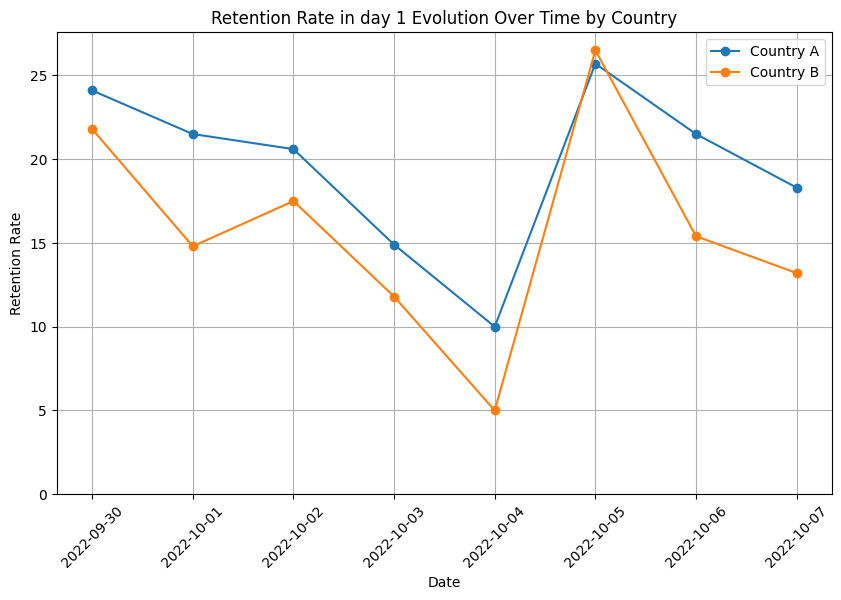

In [601]:
# @title Plotting Retention over Time by Country
# Separate the data by country
df_a = query_retention[query_retention['country'] == 'A']
df_b = query_retention[query_retention['country'] == 'B']

# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(df_a['day_0_date'], df_a['retention_rate'], marker='o', label='Country A')
plt.plot(df_b['day_0_date'], df_b['retention_rate'], marker='o', label='Country B')

# Add titles and labels
plt.title('Retention Rate in day 1 Evolution Over Time by Country')
plt.xlabel('Date')
plt.ylabel('Retention Rate')

# Set y-axis to start at 0
plt.ylim(bottom=0)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show grid
plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.show()

From the provided data:

*   Decreasing Trend: The retention rate appears to generally decrease from 2022-09-30 (23.2%) to 2022-10-04 (7.6%), indicating a potential issue early in the period.
*   Recovery: There is a notable recovery in retention rate on 2022-10-05 (26.0%), suggesting a positive event or change that day.
*   Stabilization: Post-recovery, the retention rates seem to stabilize somewhat around the 18% mark, indicating that whatever caused the spike on 2022-10-05 had a lasting positive impact, but didn't sustain at the peak level.




### Appearance per cohort

In [602]:
# @title Appearance by cohort
query_cohort_appearance = """
WITH cohort AS (
    SELECT
        user_pseudo_id,
        DATE(day_0_date) AS cohort_day
    FROM df_raw_clean
    WHERE day_0_date IS NOT NULL
    GROUP BY user_pseudo_id
),
activity AS (
    SELECT DISTINCT
        user_pseudo_id,
        DATE(date_format) AS activity_day
    FROM df_raw_clean
    GROUP BY user_pseudo_id, DATE(date_format)
),
cohort_activity AS (
    SELECT
        c.cohort_day,
        a.activity_day,
        COUNT(DISTINCT a.user_pseudo_id) AS active_users
    FROM cohort c
    JOIN activity a ON c.user_pseudo_id = a.user_pseudo_id
    WHERE a.activity_day >= c.cohort_day
    GROUP BY c.cohort_day, a.activity_day
),
cohort_retention AS (
    SELECT
        cohort_day,
        JULIANDAY(activity_day) - JULIANDAY(cohort_day) AS day_diff,
        active_users
    FROM cohort_activity
)
SELECT
    cohort_day,
    SUM(CASE WHEN day_diff = 0 THEN active_users ELSE 0 END) AS day_0,
    SUM(CASE WHEN day_diff = 1 THEN active_users ELSE 0 END) AS day_1,
    SUM(CASE WHEN day_diff = 2 THEN active_users ELSE 0 END) AS day_2,
    SUM(CASE WHEN day_diff = 3 THEN active_users ELSE 0 END) AS day_3,
    SUM(CASE WHEN day_diff = 4 THEN active_users ELSE 0 END) AS day_4,
    SUM(CASE WHEN day_diff = 5 THEN active_users ELSE 0 END) AS day_5,
    SUM(CASE WHEN day_diff = 6 THEN active_users ELSE 0 END) AS day_6,
    SUM(CASE WHEN day_diff = 7 THEN active_users ELSE 0 END) AS day_7
FROM cohort_retention
GROUP BY cohort_day
ORDER BY cohort_day;
"""

# Execute the query and load results into a DataFrame
result_cohort_appearance = pd.read_sql_query(query_cohort_appearance, conn)

# Display the result
result_cohort_appearance

,cohort_day,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,2022-09-30,483,112,47,24,17,10,19,7
1,2022-10-01,1148,213,100,57,42,55,57,50
2,2022-10-02,1179,226,76,43,57,53,45,0
3,2022-10-03,947,127,47,37,32,23,0,0
4,2022-10-04,498,38,47,27,26,0,0,0
5,2022-10-05,465,121,44,38,0,0,0,0
6,2022-10-06,876,163,71,0,0,0,0,0
7,2022-10-07,763,121,0,0,0,0,0,0


To ensure the numbers are correct I did some manual checking with the following code, to see for Cohort 2022-09-3 what the appareance had been in the following days.



```
df_raw_clean[(df_raw_clean['day_0_date']==pd.to_datetime('2022-09-30').date() )&
 (df_raw_clean['date_format'].dt.date == pd.to_datetime('2022-10-02').date() )]['user_pseudo_id'].nunique()
 ```

 This returned the distinct count of users from the selected cohort in a specific day.



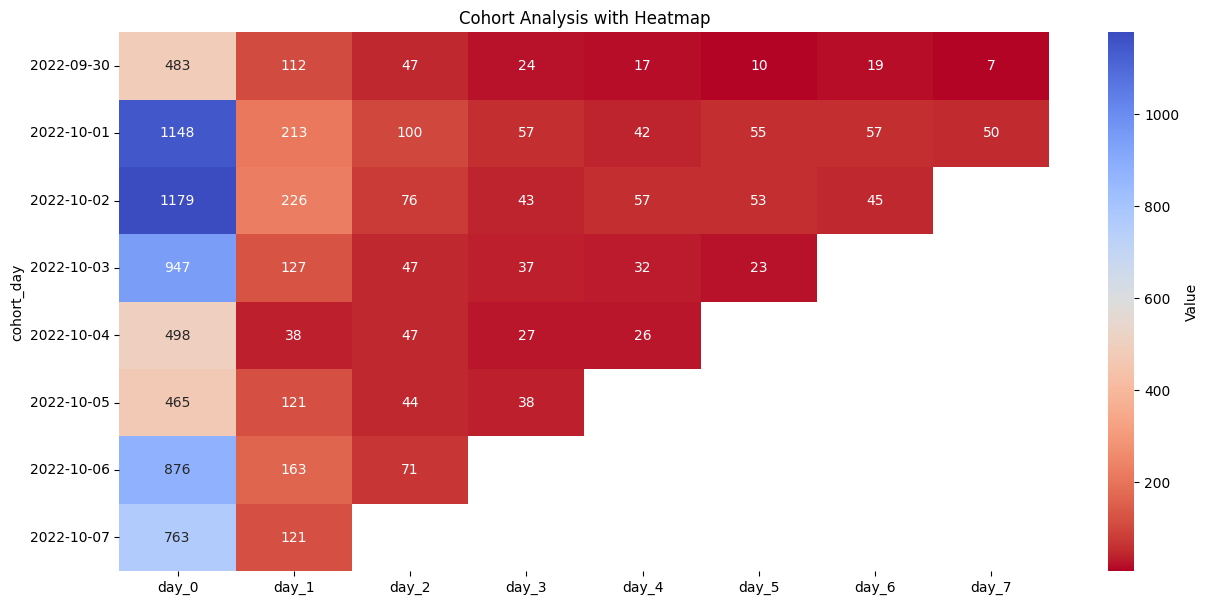

In [603]:
# @title Plotting appearance by cohort


df2 = pd.DataFrame(result_cohort_appearance)

# Setting the cohort_day as the index
df2.set_index('cohort_day', inplace=True)
mask = df2 == 0


# Plotting the heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(df2, annot=True, cmap='coolwarm_r', fmt='g', mask=mask, cbar_kws={'label': 'Value'})
plt.title('Cohort Analysis with Heatmap')
plt.show()

In [604]:
# @title Query Appearance Rate by Cohort


query_cohort_appearance_rate = """
WITH cohort AS (
    SELECT
        user_pseudo_id,
        DATE(day_0_date) AS cohort_day
    FROM df_raw_clean
    WHERE day_0_date IS NOT NULL
    GROUP BY user_pseudo_id
),
activity AS (
    SELECT DISTINCT
        user_pseudo_id,
        DATE(date_format) AS activity_day
    FROM df_raw_clean
    GROUP BY user_pseudo_id, DATE(date_format)
),
cohort_activity AS (
    SELECT
        c.cohort_day,
        a.activity_day,
        COUNT(DISTINCT a.user_pseudo_id) AS active_users
    FROM cohort c
    JOIN activity a ON c.user_pseudo_id = a.user_pseudo_id
    WHERE a.activity_day >= c.cohort_day
    GROUP BY c.cohort_day, a.activity_day
),
cohort_retention AS (
    SELECT
        cohort_day,
        JULIANDAY(activity_day) - JULIANDAY(cohort_day) AS day_diff,
        active_users
    FROM cohort_activity
),
cohort_size AS (
    SELECT
        cohort_day,
        COUNT(DISTINCT user_pseudo_id) AS cohort_size
    FROM cohort
    GROUP BY cohort_day
)
SELECT
    cr.cohort_day,
    ROUND(100.0 * SUM(CASE WHEN cr.day_diff = 1 THEN cr.active_users ELSE 0 END) / cs.cohort_size,2) AS day_1,
    ROUND(100.0 * SUM(CASE WHEN cr.day_diff = 2 THEN cr.active_users ELSE 0 END) / cs.cohort_size,2) AS day_2,
    ROUND(100.0 * SUM(CASE WHEN cr.day_diff = 3 THEN cr.active_users ELSE 0 END) / cs.cohort_size,2) AS day_3,
    ROUND(100.0 * SUM(CASE WHEN cr.day_diff = 4 THEN cr.active_users ELSE 0 END) / cs.cohort_size,2) AS day_4,
    ROUND(100.0 * SUM(CASE WHEN cr.day_diff = 5 THEN cr.active_users ELSE 0 END) / cs.cohort_size,2) AS day_5,
    ROUND(100.0 * SUM(CASE WHEN cr.day_diff = 6 THEN cr.active_users ELSE 0 END) / cs.cohort_size,2) AS day_6,
    ROUND(100.0 * SUM(CASE WHEN cr.day_diff = 7 THEN cr.active_users ELSE 0 END) / cs.cohort_size,2) AS day_7
FROM cohort_retention cr
JOIN cohort_size cs ON cr.cohort_day = cs.cohort_day
GROUP BY cr.cohort_day, cs.cohort_size
ORDER BY cr.cohort_day;
"""

result_cohort_appearance_rate = pd.read_sql_query(query_cohort_appearance_rate, conn)
result_cohort_appearance_rate

,cohort_day,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,2022-09-30,23.19,9.73,4.97,3.52,2.07,3.93,1.45
1,2022-10-01,18.55,8.71,4.97,3.66,4.79,4.97,4.36
2,2022-10-02,19.17,6.45,3.65,4.83,4.50,3.82,0.00
3,2022-10-03,13.41,4.96,3.91,3.38,2.43,0.00,0.00
4,2022-10-04,7.63,9.44,5.42,5.22,0.00,0.00,0.00
5,2022-10-05,26.02,9.46,8.17,0.00,0.00,0.00,0.00
6,2022-10-06,18.61,8.11,0.00,0.00,0.00,0.00,0.00
7,2022-10-07,15.86,0.00,0.00,0.00,0.00,0.00,0.00


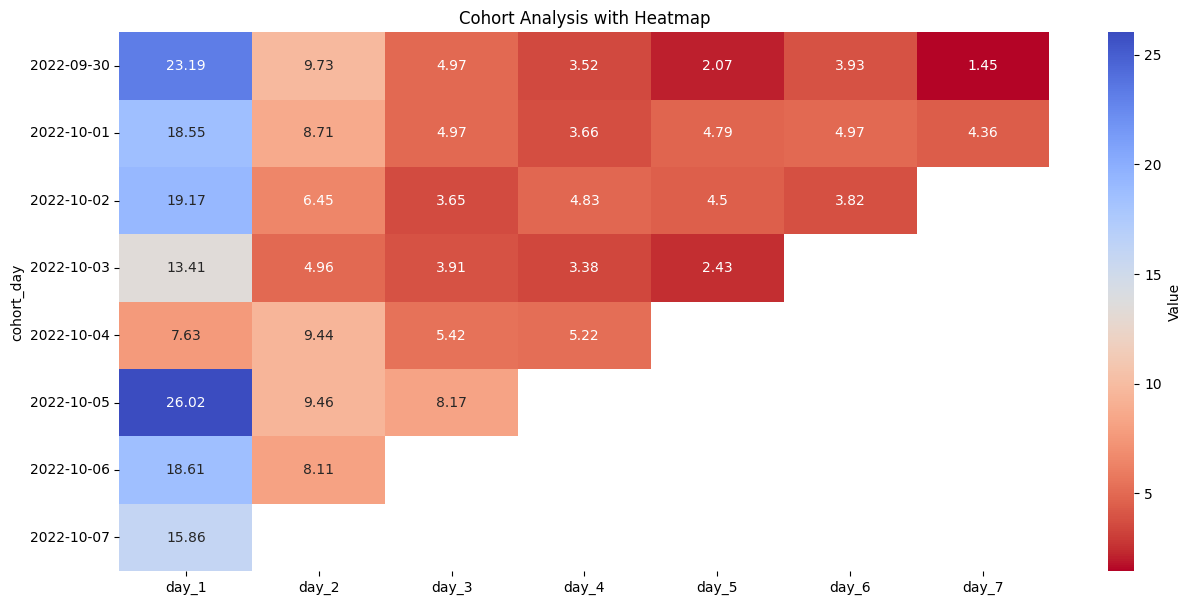

In [605]:
# @title Plotting Appearance Rate by Cohort
df2 = pd.DataFrame(result_cohort_appearance_rate)

# Setting the cohort_day as the index
df2.set_index('cohort_day', inplace=True)
mask = df2 == 0



plt.figure(figsize=(15, 7))
sns.heatmap(df2, annot=True, cmap='coolwarm_r', fmt='g', mask=mask, cbar_kws={'label': 'Value'})
plt.title('Cohort Analysis with Heatmap')
plt.show()

### Q1 Conclusions

This decline in retention rates suggests that there may be challenges in retaining users over time in both countries. It would be essential to investigate further to understand the reasons behind this trend. Possible factors could include issues with the onboarding process, user experience, or competition from other platforms.

Additionally, it's worth noting the fluctuation in retention rates from day to day, indicating potential variability in user behavior or the effectiveness of retention strategies on different days.

In conclusion, while the initial retention rates are relatively high, there is room for improvement in maintaining user engagement and retention over time in both countries A and B. Further analysis and action may be needed to address this issue and ensure long-term user satisfaction and loyalty.

**Initial Engagement:** The number of users engaged on day 0 (registration day) varies across cohorts, indicating potential fluctuations in user acquisition or onboarding effectiveness.

**Retention Decline:** Across all cohorts and days, there is a consistent decline in the number of users remaining engaged with the platform. This decline suggests that user retention is a challenge, and efforts should be made to improve retention strategies.

**Retention Rates:** By calculating the retention rates for each cohort on day 1 (the next day after registration) and subsequent days, we can observe the percentage of users retained over time. Lower retention rates indicate that a smaller proportion of users are returning to the platform after their initial interaction.

**Cohort Performance:** Analyzing the retention rates across different cohorts allows us to identify cohorts that exhibit higher or lower retention rates. Understanding the characteristics of these cohorts can help tailor retention strategies to better meet the needs of specific user groups.

**Engagement Trends:** By examining the daily engagement numbers, we can identify trends in user behavior over time. For example, sudden drops in engagement may indicate issues with the platform or changes in user preferences.

**Opportunities for Improvement:** Identifying cohorts with particularly low retention rates or observing trends in user engagement can highlight areas for improvement in user onboarding, product features, or communication strategies.

## Q2

In this case I will carry out the analysis using Pandas.

The stepts I will follow will be the next:


1.   Identify users retained
2.   Identify the events each user interacted with within the first 5 minutes
3.   Find the average rate of return



The reason why I will separate the users who have been retained is because after filtering the dataframe to look at the events that took place within the first 300 seconds, we will lose this information.


### Preparing necessary tables

In [606]:
# To create the dataframe I will simply get the users that where considered retained in Day_1 and drop all duplicates
retained_users = df_raw_clean[df_raw_clean['retained'] == 1]
retained_users = retained_users[['user_pseudo_id']].drop_duplicates()
retained_users['user_retained'] = 1
retained_users

,user_pseudo_id,user_retained
10032,user_151,1
10765,user_168,1
14449,user_253,1
14763,user_263,1
15285,user_282,1
...,...,...
704681,user_11465,1
704974,user_11466,1
706445,user_9694,1
707156,user_11487,1


To calculate the time spent between an event and the time of first open, I will add to the main DF a field with this second mentioned timestamp.

In [607]:
user_first_open = df_raw_clean[df_raw_clean['event_name'] == 'first_open'][['user_pseudo_id','date_format']].rename(columns={"date_format": "timestamp_f_open"})
user_first_open.head(2)

,user_pseudo_id,timestamp_f_open
4,user_0,2022-10-08 23:59:25.730000+00:00
461,user_10,2022-10-08 23:56:10.077000+00:00


In this step, I will combine the table we have previously created and drop all the entries that do not have a day_0, the reason being, that same as before, this rows will now have data for their day after, thus affecting the rates.

In [608]:
#I will merge the df created before to create a df with only the users that have event_name 'first_open', i will do so by using an inner join.
df_event_retention = pd.merge(df_raw_clean,user_first_open , on = 'user_pseudo_id', how='inner' )

# I will also drop the columns were the day_0_date is null, since they will not help us to calculate the retention.
df_event_retention = df_event_retention[df_event_retention['day_0_date'].isna()== False]

#We no longer need the rows 'first_open'
df_event_retention = df_event_retention[df_event_retention['event_name']!= 'first_open']
df_event_retention

,country,user_pseudo_id,event_name,date_format,day_0_date,retained,timestamp_f_open
3,B,user_1,event2,2022-10-08 23:59:35.218000+00:00,2022-10-01,0,2022-10-01 08:28:22.138000+00:00
4,B,user_1,event3,2022-10-01 08:29:18.756000+00:00,2022-10-01,0,2022-10-01 08:28:22.138000+00:00
5,B,user_1,register_mobile,2022-10-01 08:29:04.844000+00:00,2022-10-01,0,2022-10-01 08:28:22.138000+00:00
6,B,user_1,event1,2022-10-01 08:29:04.737010+00:00,2022-10-01,0,2022-10-01 08:28:22.138000+00:00
9661,B,user_15,event3,2022-10-08 23:55:30.966000+00:00,2022-10-05,0,2022-10-05 21:08:38.732000+00:00
...,...,...,...,...,...,...,...
533628,B,user_12155,register_mobile,2022-09-30 16:09:51.288000+00:00,2022-09-30,0,2022-09-30 16:07:53.611000+00:00
533629,B,user_12155,event1,2022-09-30 16:09:51.198010+00:00,2022-09-30,0,2022-09-30 16:07:53.611000+00:00
533630,B,user_12155,event3,2022-09-30 16:08:36.259000+00:00,2022-09-30,0,2022-09-30 16:07:53.611000+00:00
533632,B,user_12157,register_mobile,2022-09-30 16:03:51.214000+00:00,2022-09-30,0,2022-09-30 16:03:09.443000+00:00


The last step prior to the analysis will be to create an additional field to only maintain the events that took place 5 minutes after the first open took place.

In [609]:
#if formula to add an additional column that assigns 1 or 0 to filter the dataframe.
df_event_retention['under_5'] = np.where((df_event_retention['date_format']-df_event_retention['timestamp_f_open'] ).dt.total_seconds()  < 300,1,0)

#Here we filter out all events that occured after the specified time.
df_event_retention = df_event_retention[df_event_retention['under_5']== 1]

#Dropping unnecessary columns
df_event_retention = df_event_retention.drop(columns=['timestamp_f_open', 'under_5','retained']).copy()

df_event_retention

,country,user_pseudo_id,event_name,date_format,day_0_date
4,B,user_1,event3,2022-10-01 08:29:18.756000+00:00,2022-10-01
5,B,user_1,register_mobile,2022-10-01 08:29:04.844000+00:00,2022-10-01
6,B,user_1,event1,2022-10-01 08:29:04.737010+00:00,2022-10-01
12750,B,user_15,event8,2022-10-05 21:13:08.025010+00:00,2022-10-05
12751,B,user_15,event3,2022-10-05 21:12:54.844000+00:00,2022-10-05
...,...,...,...,...,...
533628,B,user_12155,register_mobile,2022-09-30 16:09:51.288000+00:00,2022-09-30
533629,B,user_12155,event1,2022-09-30 16:09:51.198010+00:00,2022-09-30
533630,B,user_12155,event3,2022-09-30 16:08:36.259000+00:00,2022-09-30
533632,B,user_12157,register_mobile,2022-09-30 16:03:51.214000+00:00,2022-09-30


### Combining new Tables

Once all the data is ready, we add the retained DF we had previously created and calculate the average return per event. (We still defined return as coming back the day after day_0)

In [610]:
df_final_event_retention = pd.merge(df_event_retention, retained_users, on= 'user_pseudo_id', how= 'left')
df_final_event_retention['user_retained'] = np.where(df_final_event_retention['user_retained'].isna(), 0,1)
df_final_event_retention = df_final_event_retention.drop(columns=['date_format']).drop_duplicates().copy()
df_final_event_retention

,country,user_pseudo_id,event_name,day_0_date,user_retained
0,B,user_1,event3,2022-10-01,0
1,B,user_1,register_mobile,2022-10-01,0
2,B,user_1,event1,2022-10-01,0
3,B,user_15,event8,2022-10-05,1
4,B,user_15,event3,2022-10-05,1
...,...,...,...,...,...
139780,B,user_12155,register_mobile,2022-09-30,0
139781,B,user_12155,event1,2022-09-30,0
139782,B,user_12155,event3,2022-09-30,0
139783,B,user_12157,register_mobile,2022-09-30,0


In [611]:
top_5_events = df_final_event_retention.groupby('event_name').agg({'user_retained': 'mean'}).sort_values(by='user_retained',ascending=False).reset_index().head(5)
top_5_events

,event_name,user_retained
0,event2,0.500000
1,event11,0.500000
2,event72,0.500000
3,event43,0.363636
4,event80,0.363636


### Weighting Nº Events

This are the top 5 events sorted by users retained, however, I think it'd be interesting to see if they are the sole reason why the user was retained or if we should see if other events had taken place simultaneously.

To do so I will include the total number of events to see the 'weight' of each one.

Prior to this, I will save in a list the top 5 values, to later on see if after weighting the values some events match.

In [612]:
#Here are the top 5 unweighter events
top_event = [i for i in top_5_events.event_name]
top_event

['event2', 'event11', 'event72', 'event43', 'event80']

To weight, I will see with how many events a user interacted during the 5 minutes after first_open, and later, take it into consideration when calculating the average return

In [613]:
#Dataframe with the number of events in the first 5 minutes by user.
n_events_per_user = df_final_event_retention.groupby('user_pseudo_id')['event_name'].count().reset_index().rename(columns={'event_name': 'n_events'})

Here we have the DataFrame with the new added column of n_event in first 5 minutes.

In [614]:
df_final_event_weighted = pd.merge(df_final_event_retention,n_events_per_user, on ='user_pseudo_id')
df_final_event_weighted

,country,user_pseudo_id,event_name,day_0_date,user_retained,n_events
0,B,user_1,event3,2022-10-01,0,3
1,B,user_1,register_mobile,2022-10-01,0,3
2,B,user_1,event1,2022-10-01,0,3
3,B,user_15,event8,2022-10-05,1,8
4,B,user_15,event3,2022-10-05,1,8
...,...,...,...,...,...,...
37193,B,user_12155,register_mobile,2022-09-30,0,4
37194,B,user_12155,event1,2022-09-30,0,4
37195,B,user_12155,event3,2022-09-30,0,4
37196,B,user_12157,register_mobile,2022-09-30,0,2


In [615]:
#Here we take into consideration the number of events and wether the user was retained or not.
df_final_event_weighted['weighted_retention'] = df_final_event_weighted['user_retained'] / df_final_event_weighted['n_events']

# Group by 'event_name' and calculate the weighted average retention
weighted_avg_retention = df_final_event_weighted.groupby('event_name').apply(
    lambda x: (x['weighted_retention'] * x['n_events']).sum() / x['n_events'].sum()
).reset_index(name='weighted_avg_retention')
top_5_weighted_events = weighted_avg_retention.sort_values(by='weighted_avg_retention', ascending=False).head(5)

top_5_weighted_events

,event_name,weighted_avg_retention
2,event11,0.076923
67,event72,0.066667
11,event2,0.066667
36,event43,0.041237
76,event82,0.038721


I will not get these 5 events to see how many match with our previous result.

In [616]:
top_weighted_events = [i for i in top_5_weighted_events.event_name]
top_weighted_events

['event11', 'event72', 'event2', 'event43', 'event82']

In [617]:
matching_values = [value for value in top_event if value in top_weighted_events]
matching_values

['event2', 'event11', 'event72', 'event43']

Now that we have identified events that match I will see how users behave after interacting with these events.

 To do so I will replicate a query I previosuly used, but include a for loop to see how many users returned the days following their interactions.

In [622]:
# @title Query Appearance of users by Top Events
# List of events
events = ['event2', 'event11', 'event72', 'event43']
# List to store DataFrames for each event
df_list = []
# DataFrame to store results
df_final = pd.DataFrame(columns=['event_name', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7'])

# Loop over events
for event in events:
    # Query template
    query_event_appearance = f"""
    WITH filtered_users AS (
        SELECT DISTINCT
            user_pseudo_id
        FROM df_raw_clean
        WHERE event_name = '{event}'
    ),
    cohort AS (
        SELECT
            user_pseudo_id,
            DATE(day_0_date) AS cohort_day
        FROM df_raw_clean
        WHERE day_0_date IS NOT NULL
        AND user_pseudo_id IN (SELECT user_pseudo_id FROM filtered_users)
        GROUP BY user_pseudo_id
    ),
    activity AS (
        SELECT DISTINCT
            user_pseudo_id,
            DATE(date_format) AS activity_day
        FROM df_raw_clean
        WHERE user_pseudo_id IN (SELECT user_pseudo_id FROM filtered_users)
        GROUP BY user_pseudo_id, DATE(date_format)
    ),
    cohort_activity AS (
        SELECT
            c.cohort_day,
            a.activity_day,
            COUNT(DISTINCT a.user_pseudo_id) AS active_users
        FROM cohort c
        JOIN activity a ON c.user_pseudo_id = a.user_pseudo_id
        WHERE a.activity_day >= c.cohort_day
        GROUP BY c.cohort_day, a.activity_day
    ),
    cohort_retention AS (
        SELECT
            cohort_day,
            JULIANDAY(activity_day) - JULIANDAY(cohort_day) AS day_diff,
            active_users
        FROM cohort_activity
    )
    SELECT
        '{event}' AS event_name,
        SUM(CASE WHEN day_diff = 0 THEN active_users ELSE 0 END) AS day_0,
        SUM(CASE WHEN day_diff = 1 THEN active_users ELSE 0 END) AS day_1,
        SUM(CASE WHEN day_diff = 2 THEN active_users ELSE 0 END) AS day_2,
        SUM(CASE WHEN day_diff = 3 THEN active_users ELSE 0 END) AS day_3,
        SUM(CASE WHEN day_diff = 4 THEN active_users ELSE 0 END) AS day_4,
        SUM(CASE WHEN day_diff = 5 THEN active_users ELSE 0 END) AS day_5,
        SUM(CASE WHEN day_diff = 6 THEN active_users ELSE 0 END) AS day_6,
        SUM(CASE WHEN day_diff = 7 THEN active_users ELSE 0 END) AS day_7
    FROM cohort_retention;
    """

    # Execute query and append results to DataFrame
    df_event = pd.read_sql_query(query_event_appearance, conn)
    df_list.append(df_event)

# Concatenate DataFrames for each event
df_final = pd.concat(df_list, ignore_index=True)

df_final_percentage = df_final.copy()

df_final_percentage['day_1_percentage']  = df_final_percentage['day_1']  / df_final_percentage['day_0']
df_final_percentage['day_2_percentage']  = df_final_percentage['day_2']  / df_final_percentage['day_0']
df_final_percentage['day_3_percentage']  = df_final_percentage['day_3']  / df_final_percentage['day_0']
df_final_percentage['day_4_percentage']  = df_final_percentage['day_4']  / df_final_percentage['day_0']
df_final_percentage['day_5_percentage']  = df_final_percentage['day_5']  / df_final_percentage['day_0']
df_final_percentage['day_6_percentage']  = df_final_percentage['day_6']  / df_final_percentage['day_0']
df_final_percentage['day_7_percentage']  = df_final_percentage['day_7']  / df_final_percentage['day_0']


df_final_percentage.drop(columns=['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6', 'day_7'],inplace=True)
df_final_percentage.fillna(0, inplace=True)

df_final_percentage


,event_name,day_1_percentage,day_2_percentage,day_3_percentage,day_4_percentage,day_5_percentage,day_6_percentage,day_7_percentage
0,event2,0.454277,0.318584,0.206490,0.126844,0.129794,0.168142,0.123894
1,event11,0.333333,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000
2,event72,0.404255,0.319149,0.106383,0.106383,0.106383,0.063830,0.042553
3,event43,0.488636,0.227273,0.170455,0.102273,0.079545,0.090909,0.022727


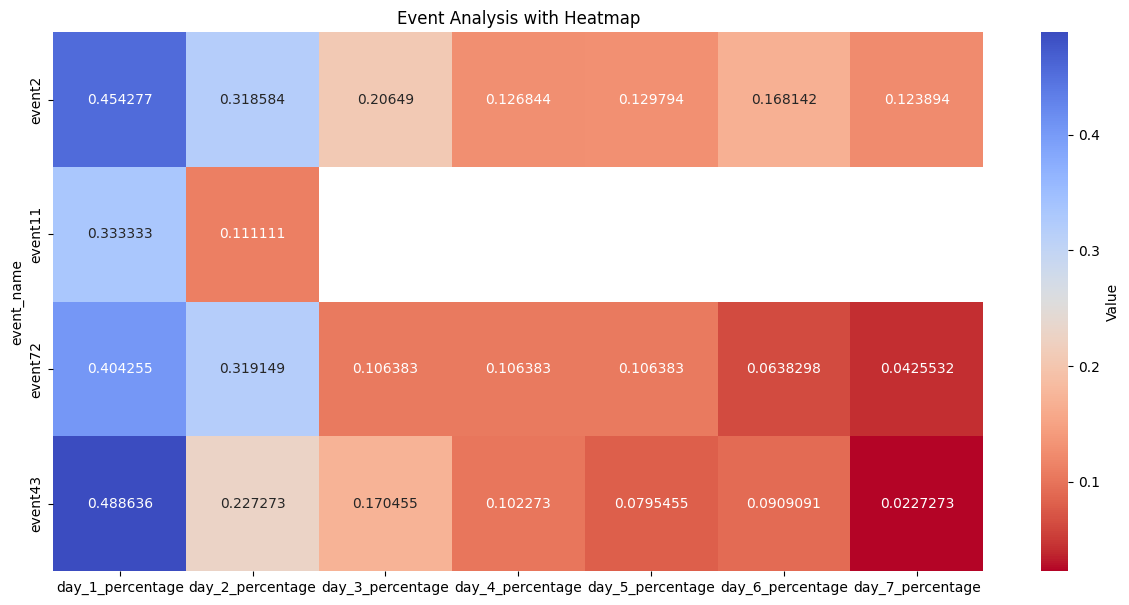

In [624]:
# @title Plotting Appearance Rate by Event
df2 = pd.DataFrame(df_final_percentage)


df2.set_index('event_name', inplace=True)

mask = df2 == 0


plt.figure(figsize=(15, 7))
sns.heatmap(df2, annot=True, cmap='coolwarm_r', fmt='g', mask=mask, cbar_kws={'label': 'Value'})
plt.title('Event Analysis with Heatmap')
plt.show()

In [620]:
df_final

,event_name,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,event2,339,154,108,70,43,44,57,42
1,event11,9,3,1,0,0,0,0,0
2,event72,47,19,15,5,5,5,3,2
3,event43,88,43,20,15,9,7,8,2


### Conclusions Q2

Event2:

On day 1, 45.43% of users who engaged with event2 were active.
This percentage increased steadily over the next few days, peaking at 102.33% on day 5, indicating that more users engaged on day 5 than on day 1.
There was a slight decrease in engagement on day 6 and day 7, but overall, the engagement remains relatively high throughout the week.
Event11:

For event11, there is a high engagement percentage (33.33%) on day 1, but it drops to 0% for the following days. This indicates that all users who engaged with event11 on day 1 did not return for subsequent days.
Event72:

Engagement for event72 starts at 40.43% on day 1 and increases steadily over the week, peaking at 100% on day 4 and day 5.
There is a slight decrease in engagement on day 6 and day 7, but overall, the engagement remains relatively high throughout the week.
Event43:

Event43 starts with a relatively high engagement percentage (48.86%) on day 1.
Engagement fluctuates over the week, with some days showing higher engagement (e.g., day 3 and day 6) and others showing lower engagement (e.g., day 2 and day 7).
Overall, the analysis helps identify trends in user engagement over time for each event. Events like event2 and event72 show consistent or increasing engagement over the week, while event11 has a one-time spike in engagement on day 1 but no sustained engagement in subsequent days. Event43 shows fluctuating engagement levels over the week. These insights can be valuable for understanding user behavior and optimizing strategies to improve engagement and retention for each event.

**Event2**:

On day 0, there were 339 users who engaged with event2.
The percentage of users engaging with event2 drops from day 0 to day 1, indicating a decrease in engagement.
However, despite the decrease in percentage, the actual number of users engaging with event2 on day 1 is still substantial at 154 users.
The engagement percentage fluctuates over the week, with varying numbers of users each day.


**Event11**:

On day 0, there were 9 users who engaged with event11.
There is a high percentage of engagement (33.33%) on day 1, but the number of users drops to 3 on day 1.
Subsequently, there are no users engaging with event11 on days 2 to 7, resulting in a steady decline in both percentage and actual user count.


**Event72**:

On day 0, there were 47 users who engaged with event72.
Engagement for event72 declines slightly from day 0 to day 1, but the number of users engaging with the event remains relatively stable over the week.
There is a slight decrease in both percentage and actual user count towards the end of the week.


**Event43**:

On day 0, there were 88 users who engaged with event43.
The percentage of engagement for event43 is relatively high on day 0, but it fluctuates over the week.
The number of users engaging with event43 decreases gradually over the week, with fewer users on days 6 and 7 compared to earlier days.

# Ideas for next step analysis



1. **Correlation Analysis**:
   - Investigate correlations between various factors such as:
     - The number of times a user interacts with specific events and their retention over time.
     - The frequency of interactions with core events and overall user engagement metrics.
     - The relationship between user demographics (if available) and their interaction patterns with events.

2. **Cohort Analysis**:
   - Conduct cohort analysis to examine how different groups of users behave over time.
   - Create cohorts based on factors like sign-up date, user characteristics, or interaction patterns.
   - Analyze retention rates, engagement levels, and conversion rates for each cohort over time.

3. **Segmentation**:
   - Segment users based on their interaction patterns with events or other relevant factors.
   - Compare retention rates, engagement metrics, and other KPIs across different user segments.
   The objetive here would be to identify high-value segments and tailor marketing strategies or product features to meet their needs.

4. **Event Funnel Analysis**:
   - Construct event funnels to visualize the user journey from event to event.
   - Analyze conversion rates at each step of the funnel and identify potential bottlenecks or areas for optimization.
   - Compare event funnels for different user segments or time periods to identify trends or anomalies.

5. **Churn Analysis**:
   - Analyze user churn rates and identify factors that contribute to churn.
   - Investigate patterns or behaviors exhibited by users who churn compared to those who remain active.

6. **A/B Testing**:
   - Conduct A/B tests to evaluate the impact of changes or interventions on user behavior.
   - Test different versions of events, user interfaces, or marketing campaigns to determine their effectiveness in driving engagement and retention.
